In [1]:
import os

ROOT_DIR = '/content/drive/MyDrive/img'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'COVID-19_Radiography')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [4]:
import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'COVID-19_Radiography.zip'), 'r') as target_file:
  target_file.extractall(DATA_ROOT_DIR)

In [2]:
import shutil
import glob

total_file_list = glob.glob(os.path.join(DATA_ROOT_DIR, 'COVID-19_Radiography_Dataset/*'))
label_name_list = [file_name.split('/')[-1].strip() for file_name in total_file_list if os.path.isdir(file_name) == True]

for label_name in label_name_list:
  src_dir_path = os.path.join(DATA_ROOT_DIR, 'COVID-19_Radiography_Dataset/' + label_name + '/images')
  dst_dir_path = os.path.join(DATA_ROOT_DIR, 'train/' + label_name)

  try:
    shutil.copytree(src_dir_path, dst_dir_path)
  except Exception as err:
    print(str(err))

if not os.path.exists(TEST_DATA_ROOT_DIR):
  os.mkdir(TEST_DATA_ROOT_DIR)

for label_name in label_name_list:
  if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, label_name)):
    os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))

In [3]:
import random

MOVE_RATIO = 0.2 # train : test = 80 : 20, 즉 train 데이터 20% 데이터를 test 데이터로 사용

# 파일 move train_data_dir => test_data_dir

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
  # 파일 move 하기 위한 src_dir_path, dst_dir_path 설정
  # =========================================================
  src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
  dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
  # =========================================================

  train_data_file_list = os.listdir(src_dir_path)
  random.shuffle(train_data_file_list)
  split_num = int(MOVE_RATIO * len(train_data_file_list))
  test_data_file_list = train_data_file_list[0:split_num]

  for test_data_file in test_data_file_list:
    try:
      shutil.move(os.path.join(src_dir_path, test_data_file),
                  os.path.join(dst_dir_path, test_data_file))
    except Exception as err:
      print(str(err))

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                    color_mode='rgb', class_mode='sparse',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    subset='training')
validation_generator = validation_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                              color_mode='rgb', class_mode='sparse',
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                              subset='validation')
test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size=32,
                                                  color_mode='rgb', class_mode='sparse',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT))
print(train_generator.class_indices, train_generator.num_classes)

Found 6155 images belonging to 4 classes.
Found 1537 images belonging to 4 classes.
Found 1922 images belonging to 4 classes.
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3} 4


In [6]:
IMG_NUMS = 16

image_data, label_data = train_generator.next()

data = image_data[:IMG_NUMS]
label = label_data[:IMG_NUMS]

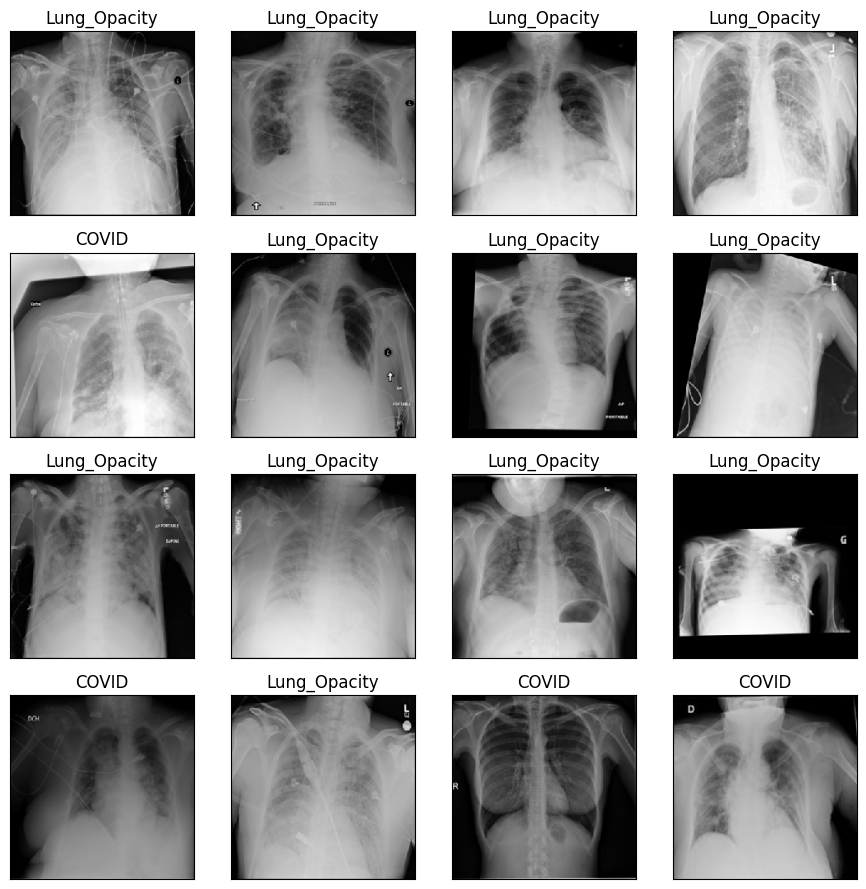

In [7]:
import matplotlib.pyplot as plt

class_dict = {0: 'COVID', 1:'Lung_Opacity', 2:'Normal', 3:'Viral Pneumonia'}

plt.figure(figsize=(9,9))

for i in range(len(label)):
  plt.subplot(4, 4, i + 1)
  plt.title(str(class_dict[label[i]]))
  plt.xticks([])
  plt.yticks([])

  plt.imshow(data[i])

plt.tight_layout()
plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet

class_nums = train_generator.num_classes

pre_trained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_nums, activation='softmax'))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['acc'])

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                         

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

hist = model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
193/193 [==============================] - 73s 226ms/step - loss: 0.8362 - acc: 0.6653 - val_loss: 0.5571 - val_acc: 0.7456
Epoch 2/20
193/193 [==============================] - 39s 201ms/step - loss: 0.2674 - acc: 0.9041 - val_loss: 0.2512 - val_acc: 0.8992
Epoch 3/20
193/193 [==============================] - 35s 183ms/step - loss: 0.1524 - acc: 0.9534 - val_loss: 0.1295 - val_acc: 0.9493
Epoch 4/20
193/193 [==============================] - 37s 190ms/step - loss: 0.0984 - acc: 0.9675 - val_loss: 0.0633 - val_acc: 0.9772
Epoch 5/20
193/193 [==============================] - 37s 189ms/step - loss: 0.0715 - acc: 0.9792 - val_loss: 0.0699 - val_acc: 0.9720
Epoch 6/20
193/193 [==============================] - 38s 194ms/step - loss: 0.0487 - acc: 0.9854 - val_loss: 0.0486 - val_acc: 0.9844
Epoch 7/20
193/193 [==============================] - 38s 195ms/step - loss: 0.0350 - acc: 0.9904 - val_loss: 0.0382 - val_acc: 0.9883
Epoch 8/20
193/193 [==============================] - 3

In [10]:
model.evaluate(test_generator)

61/61 [==============================] - 11s 173ms/step - loss: 0.0253 - acc: 0.9932


[0.02534118853509426, 0.9932361841201782]

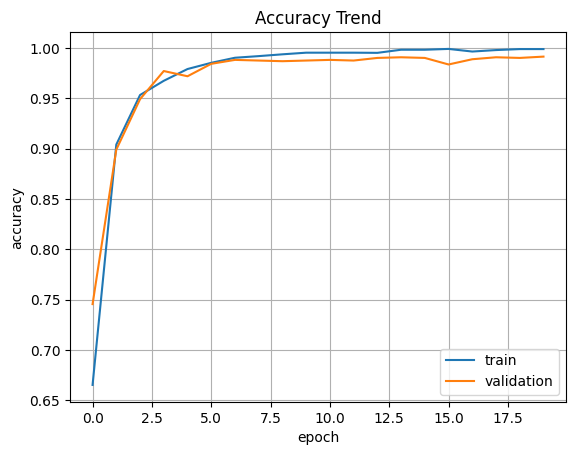

In [11]:
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.legend(loc='best')
plt.grid()
plt.show()

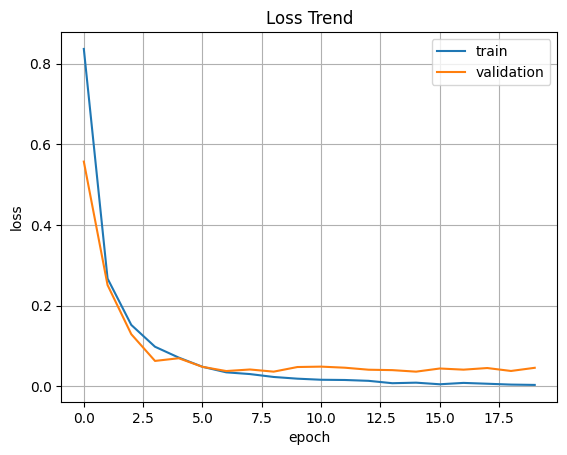

In [12]:
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.grid()
plt.show()